## setup

In [2]:
! pip install tensorflow numpy matplotlib torch torchvision pandas scikit-learn opencv-python

import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Concatenate, Flatten, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import sklearn
import sklearn.metrics
from PIL import Image

2025-07-18 12:09:04.813342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-18 12:09:04.947487: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-18 12:09:04.970928: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2025-07-18 12:09:04.970936: I tensorflow/compiler

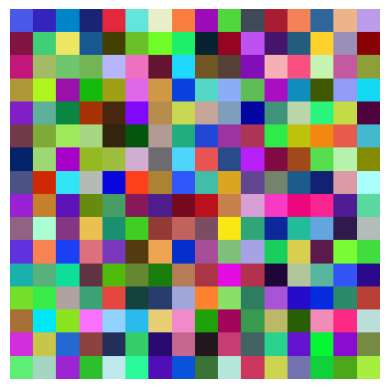

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

texture = np.random.randint(0, 256, (16, 16, 3), dtype=np.uint8)


# COMMENT THIS OUT IF YOU WANT TO TILE THE TEXTURE REPEATEDLY OVER 500x500 AREA
texture = np.array(
    Image.fromarray(texture).resize((500, 500), resample=Image.NEAREST)
)

plt.imshow(texture)
plt.axis('off')
plt.show()


In [27]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)

print("Loading validation datasets...")
val_x_ref = load_images_from_folder('validation_dataset_clean/reference')
val_eta_exp = load_images_from_folder('validation_dataset_clean/texture')
val_x_ren = load_images_from_folder('validation_dataset_clean/rendered')

Loading validation datasets...


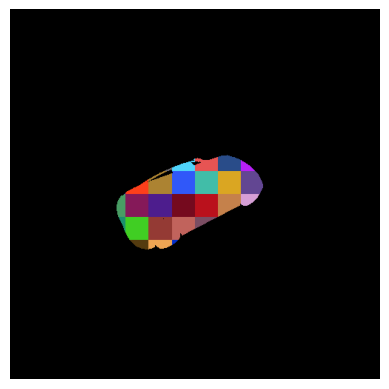

In [42]:
from PIL import Image

# Tile the texture repeatedly over the 500x500 image
tile_rows = 500 // texture.shape[0] + 1
tile_cols = 500 // texture.shape[1] + 1

tiled_texture = np.tile(texture, (tile_rows, tile_cols, 1))[:500, :500, :]

mask = np.any(val_eta_exp[65] > 0.01, axis=-1, keepdims=True)  # Shape: (500, 500, 1)

# Apply texture to masked regions
texture_mask = np.where(mask, tiled_texture, 0.0)

plt.imshow(texture_mask.astype(np.uint8))
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 88ms/step


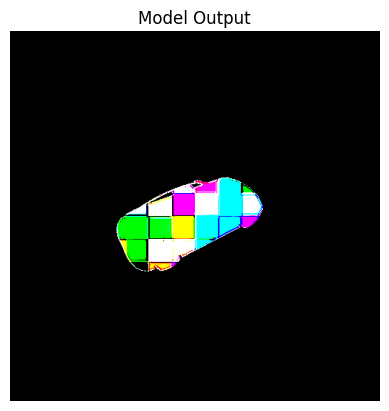

In [39]:
# Load a Keras model (replace 'model_path' with your actual model file)
model = tf.keras.models.load_model('models/k3_12epch_wo_custom_loss_model.h5')

# Prepare two inputs for prediction (example: val_x_ref[0] and val_eta_exp[0])
input1 = np.expand_dims(val_x_ref[65], axis=0)  # shape: (1, 500, 500, 3)
input2 = np.expand_dims(texture_mask, axis=0)  # shape: (1, 500, 500, 3)

# Predict using the model
outputs = model.predict([input1, input2])

# Visualise the output (assuming output shape is (1, 500, 500, 3))
plt.imshow(outputs[0])  # Display the first output
plt.axis('off')
plt.title('Model Output')
plt.show()